# This code takes in a .json file from TweetyBERT, then calculates and graphs the song duration across days of recording. Then, It figures out and graphs how often syllables show up across each day of recording.

In [16]:
import re
from datetime import datetime
import json
recording_file_path_name = '/Volumes/ROSE2-SSD/RHV_song_counts/RC7_USA5499_tweetybert_outputs/USA5499_decoded_database.json'
path_to_json_file_with_dates = '/Volumes/ROSE2-SSD/RHV_song_counts/RC7_USA5499_tweetybert_outputs/USA5499_Comp2_creation_data.json'
# Use a regular expression to find the pattern 'USA' followed by 4 digits
match = re.search(r"(USA\d{4})", path_to_json_file_with_dates)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

with open(path_to_json_file_with_dates, 'r') as f:
    json_data = json.load(f)
    # Extract surgery date and format it
json_treatment_date = json_data['treatment_date']  # Assuming single treatment date
date_obj = datetime.strptime(json_treatment_date, "%Y-%m-%d")
treatment_date = date_obj.strftime("%Y.%m.%d")  # Adjust to year-first format for consistency
print(f"Treatment date: {treatment_date}")

Animal ID: USA5499
Treatment date: 2025.02.20


### Load the .json file here, correct the dates (because TweetyBERT assumes it's always in 2024), then organize the data into a dataframe so it's easier to run calculations

In [17]:
import json
import pandas as pd
import ast
from datetime import datetime

class temp:
    def __init__(self):
        # Define the path to the JSON file
        #recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/USA5509_decoded_database.json'
        #recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/USA5336_decoded_database.json'

        # Read the JSON file
        print(f"Reading JSON file: {recording_file_path_name}")
        with open(recording_file_path_name, 'r') as f:
            decoder_data = json.load(f)['results']  # Adjusted to extract the 'results' key

        # Print the total number of songs (assuming each item in 'results' is a song)
        print(f"Total songs in JSON: {len(decoder_data)}")

        # Convert to DataFrame
        decoder_dataframe = pd.DataFrame(decoder_data)
        decoder_dataframe['syllable_onsets_offsets_ms'] = decoder_dataframe['syllable_onsets_offsets_ms'].apply(self.parse_json_safe)
        decoder_dataframe['syllable_onsets_offsets_timebins'] = decoder_dataframe['syllable_onsets_offsets_timebins'].apply(self.parse_json_safe)

        self.dataframe = decoder_dataframe

    def return_dataframe(self):
        return self.dataframe


    def parse_json_safe(self, s):
            """
            Safely parse a string representation of a JSON object.
            Handles extra quotes and converts single quotes to double quotes.
            """
            if isinstance(s, dict):
                return s  # If it's already a dictionary, return it as is
            
            if pd.isna(s):
                return {}
            
            # Remove surrounding single quotes
            s = s.strip()
            if s.startswith("''") and s.endswith("''"):
                s = s[2:-2]
            elif s.startswith("'") and s.endswith("'"):
                s = s[1:-1]
            
            if not s:
                return {}
            
            try:
                # First, attempt to parse using json
                s_json = s.replace("'", '"')
                return json.loads(s_json)
            except json.JSONDecodeError:
                try:
                    # If json fails, attempt using ast.literal_eval
                    return ast.literal_eval(s)
                except (ValueError, SyntaxError) as e:
                    print(f"Error parsing string: {s}\nError: {e}")
                    return {}
    
TEMP = temp()

decoder_dataframe = TEMP.return_dataframe()

print(decoder_dataframe.head)

Reading JSON file: /Volumes/ROSE2-SSD/RHV_song_counts/RC7_USA5499_tweetybert_outputs/USA5499_decoded_database.json
Total songs in JSON: 24368
<bound method NDFrame.head of                                       file_name        creation_date  \
0       USA5499_45679.35785226_1_22_9_56_25.wav  2025-01-22T09:56:36   
1        USA5499_45679.36067306_1_22_10_1_7.wav  2025-01-22T10:01:14   
2        USA5499_45679.36188718_1_22_10_3_8.wav  2025-01-22T10:03:18   
3       USA5499_45679.36199930_1_22_10_3_19.wav  2025-01-22T10:03:30   
4      USA5499_45679.37180980_1_22_10_19_40.wav  2025-01-22T10:19:56   
...                                         ...                  ...   
24363   USA5499_45718.64010658_3_2_17_46_50.wav  2025-03-02T17:47:02   
24364    USA5499_45718.64020219_3_2_17_47_0.wav  2025-03-02T17:47:10   
24365    USA5499_45718.64205607_3_2_17_50_5.wav  2025-03-02T17:50:10   
24366   USA5499_45718.64364099_3_2_17_52_44.wav  2025-03-02T17:52:52   
24367   USA5499_45718.64483448_3_2_1

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
import json

with open(path_to_json_file_with_dates, 'r') as f:
    json_data = json.load(f)
    # Extract surgery date and format it
json_surgery_date = json_data['treatment_date']  # Assuming single treatment date
date_obj = datetime.strptime(json_surgery_date, "%Y-%m-%d")
surgery_date = date_obj.strftime("%Y.%m.%d")  # Adjust to year-first format for consistency
print(f"Surgery date: {surgery_date}")
# Extract subdirectory creation dates from JSON data
subdirectory_dates = {subdir: data['subdirectory_creation_date'] for subdir, data in json_data['subdirectories'].items()}


# Function to extract date, time, and animal_id from the file name
def find_recording_dates_and_times(recording_file_path_name):
    try:
        file_name = recording_file_path_name.split('/')[-1]
        split_file_name_by_underscores = file_name.split('_')
        animal_id = split_file_name_by_underscores[0]
        month = split_file_name_by_underscores[2].zfill(2)
        day = split_file_name_by_underscores[3].zfill(2)
        date = f"{month}.{day}"
        hour = split_file_name_by_underscores[4].zfill(2)
        minute = split_file_name_by_underscores[5].zfill(2)
        second = split_file_name_by_underscores[6].replace('.wav', '').zfill(2)
        return animal_id, date, hour, minute, second
    except IndexError:
        print(f"Error: Unexpected format in file name {recording_file_path_name}")
        return None, None, None, None, None

# Function to update the date with year from the JSON file
def update_date_with_year(row, subdirectory_dates):
    month_day = row['Date']
    month = month_day.split('.')[0]
    for subdir, date in subdirectory_dates.items():
        year, json_month, json_day = date.split('-')
        if json_month == month:
            # Return the date in the format YYYY.MM.DD
            return f"{year}.{month_day}"
    return None

# Function to create a table and filter data where song_present is True
def make_table(input_data_frame, subdirectory_dates):
    only_song_data = input_data_frame[input_data_frame['song_present'] == True].reset_index(drop=True)
    num_files_with_song = only_song_data.shape[0]
    
    organized_data_frame = only_song_data.copy()
    organized_data_frame['Animal ID'] = [None] * num_files_with_song
    organized_data_frame['Date'] = [None] * num_files_with_song
    organized_data_frame['Hour'] = [None] * num_files_with_song
    organized_data_frame['Minute'] = [None] * num_files_with_song
    organized_data_frame['Second'] = [None] * num_files_with_song

    for i, row in only_song_data.iterrows():
        recording_file_path_name = row['file_name']
        try:
            animal_id, date, hour, minute, second = find_recording_dates_and_times(recording_file_path_name)
            organized_data_frame.at[i, 'Animal ID'] = animal_id
            organized_data_frame.at[i, 'Date'] = date
            organized_data_frame.at[i, 'Hour'] = hour
            organized_data_frame.at[i, 'Minute'] = minute
            organized_data_frame.at[i, 'Second'] = second
        except Exception as e:
            print(f"Error processing file {recording_file_path_name}: {e}")
            continue

    # Apply the year correction to the date
    organized_data_frame['Date'] = organized_data_frame.apply(lambda row: update_date_with_year(row, subdirectory_dates), axis=1)
    
    # Convert the updated 'Date' column to a proper datetime object for further handling
    organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], format='%Y.%m.%d', errors='coerce')
    
    print(f"First rows of organized_data_frame with updated dates: {organized_data_frame.head(3)}")
    return organized_data_frame

# Generate the organized data table
organized_data_frame = make_table(decoder_dataframe, subdirectory_dates)

# Find the unique dates from the recording
def find_unique_recording_dates(data_frame):
    # Extract the unique values from the 'Date' column
    unique_dates = data_frame['Date'].dt.strftime('%Y.%m.%d').unique()  # Convert back to string for display purposes
    return unique_dates

# Example usage
unique_dates = find_unique_recording_dates(organized_data_frame)
print("Unique recording dates:", unique_dates)

# Apply the function to all rows in the 'syllable_onsets_offsets_ms' column
organized_data_frame['syllable_onsets_offsets_ms_dict'] = organized_data_frame['syllable_onsets_offsets_ms']

# Now 'syllable_onsets_offsets_ms_dict' contains the cleaned and converted dictionaries
# Create a set to store all unique syllable labels
unique_syllable_labels = set()

# Iterate through each row in the 'syllable_onsets_offsets_ms_dict' column
for row in organized_data_frame['syllable_onsets_offsets_ms_dict']:
    if row:  # Check if the row is not None or empty
        # Add the keys (syllable labels) to the set
        unique_syllable_labels.update(row.keys())

# Convert the set to a sorted list (optional, for easier viewing)
unique_syllable_labels = sorted(unique_syllable_labels)

# Print or return the unique syllable labels
print("Unique syllable labels:", unique_syllable_labels)

Surgery date: 2025.02.20
First rows of organized_data_frame with updated dates:                                   file_name        creation_date  \
0  USA5499_45679.38633704_1_22_10_43_53.wav  2025-01-22T10:44:26   
1  USA5499_45679.38665937_1_22_10_44_25.wav  2025-01-22T10:44:50   
2   USA5499_45679.40621870_1_22_11_17_1.wav  2025-01-22T11:17:44   

   song_present                         syllable_onsets_offsets_ms  \
0          True  {'13': [[0.0, 1821.4285714285716], [1829.52380...   
1          True  {'9': [[0.0, 1597.4603174603176], [11168.73015...   
2          True  {'13': [[0.0, 105.23809523809524], [340.0, 126...   

                    syllable_onsets_offsets_timebins Animal ID       Date  \
0  {'13': [[0.0, 675], [678.0, 690]], '11': [[675...   USA5499 2025-01-22   
1  {'9': [[0.0, 592], [4139.0, 4491]], '1': [[592...   USA5499 2025-01-22   
2  {'13': [[0.0, 39], [125.99999999999999, 467]],...   USA5499 2025-01-22   

  Hour Minute Second  
0   10     43     53  
1   10     

## This part finds and graphs the distribution of SONG durations across days (not the phrase durations :) )

## Find, then graph the song durations for each day

        Date                    syllable_onsets_offsets_ms_dict  song_duration
0 2025-01-22  {'13': [[0.0, 1821.4285714285716], [1829.52380...    2299.047619
1 2025-01-22  {'9': [[0.0, 1597.4603174603176], [11168.73015...   21136.666667
2 2025-01-22  {'13': [[0.0, 105.23809523809524], [340.0, 126...    1605.555556
3 2025-01-22  {'13': [[0.0, 110.63492063492065], [253.650793...    2841.428571
4 2025-01-22  {'10': [[0.0, 72.85714285714286], [170.0, 393....   25769.841270


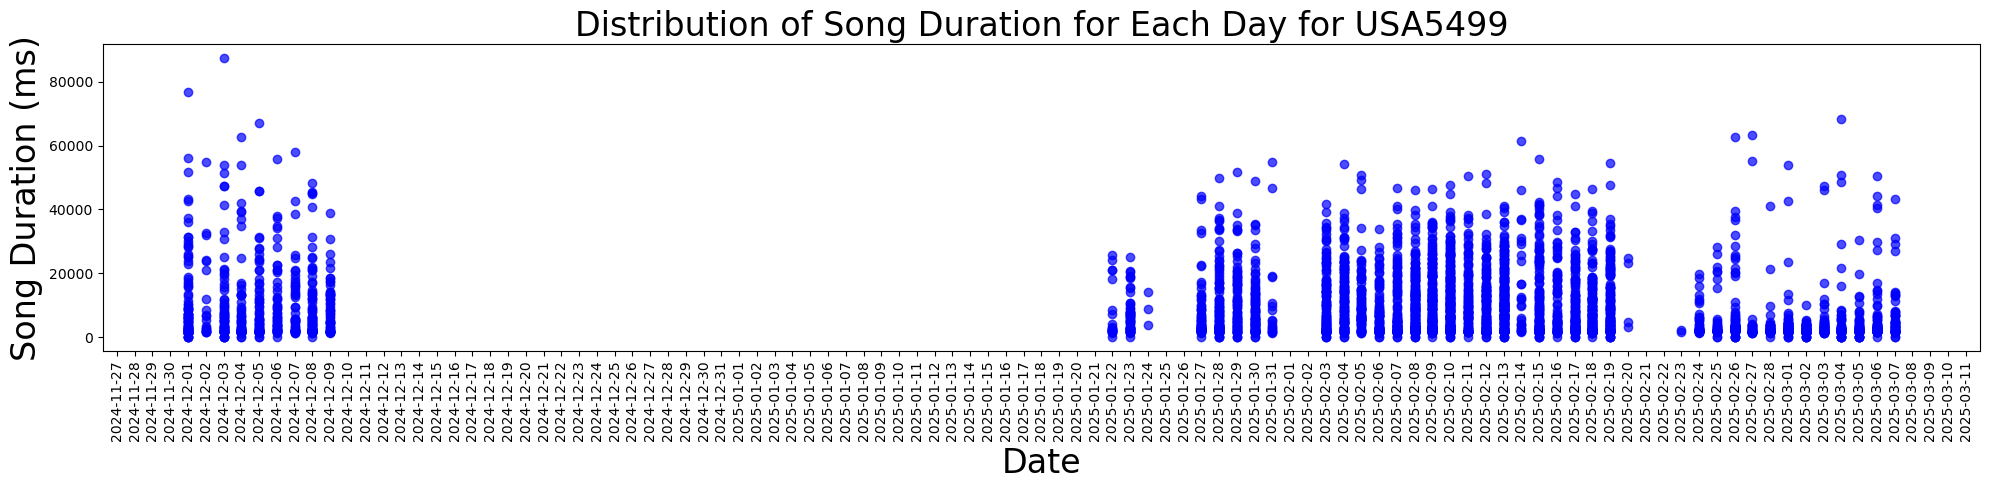

<Figure size 1000x400 with 0 Axes>

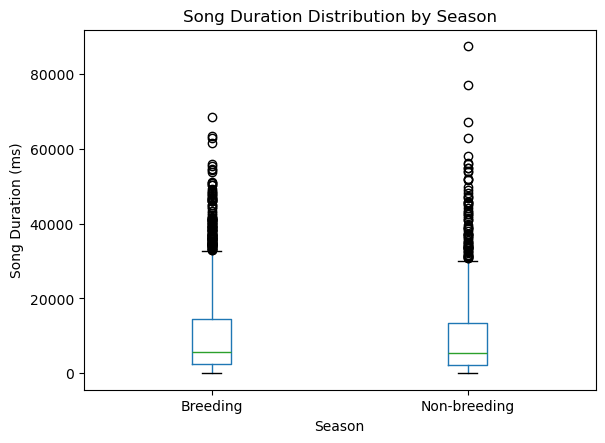

In [19]:
# Iterate over each row of the organized_data_frame
# Initialize a list to store song durations for each row
song_durations = []

# Loop through each row in the organized_data_frame
for index, row in organized_data_frame.iterrows():
    # Extract the syllable onsets/offsets dictionary for the current row
    syllable_onsets_offsets = row['syllable_onsets_offsets_ms_dict']
    
    # Initialize min and max values for each row
    min_onset = float('inf')
    max_offset = float('-inf')
    
    # Loop through each syllable's onset/offset list
    for times in syllable_onsets_offsets.values():
        for onset, offset in times:
            if onset < min_onset:
                min_onset = onset
            if offset > max_offset:
                max_offset = offset
    
    # Calculate the song duration and append it to the list
    song_duration = max_offset - min_onset
    song_durations.append(song_duration)

# Add the song_duration list as a new column in the organized_data_frame
organized_data_frame['song_duration'] = song_durations
# Use .head() to show the first few rows of the specified columns
print(organized_data_frame[['Date', 'syllable_onsets_offsets_ms_dict', 'song_duration']].head())



import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Find the minimum and maximum date of recording
min_date = organized_data_frame['Date'].min()
max_date = organized_data_frame['Date'].max()

# Generate a date range with a daily frequency from min_date to max_date
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Create scatter plot with all points in blue
plt.figure(figsize=(20, 5))

# Loop through each date in the range and check if there is data for that date
for current_date in all_dates:
    # Filter data for the current date
    daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    
    # If there is data, plot the song_duration for that date in blue
    if not daily_data.empty:
        plt.scatter(daily_data['Date'], daily_data['song_duration'], color='blue', alpha=0.7)

# Configure plot with labels, title, and an x-tick for every day in the date range
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Song Duration (ms)', fontsize = 24)
plt.title(f'Distribution of Song Duration for Each Day for {animal_id}', fontsize  =24)
plt.xticks(ticks=all_dates, labels=[date.date() for date in all_dates], rotation=90)

# Ensure all dates are displayed
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Locator for each day on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format x-axis labels
plt.tight_layout()
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Assuming 'organized_data_frame' already exists and contains 'Date' and 'song_duration' columns

# Define the breeding and non-breeding months
breeding_months = [2, 3, 4, 5, 6]      # February to June
non_breeding_months = [10, 11, 12, 1]  # October to January

# Create a new column 'Season' based on the month of each date
organized_data_frame['Season'] = organized_data_frame['Date'].dt.month.apply(
    lambda x: 'Breeding' if x in breeding_months else ('Non-breeding' if x in non_breeding_months else 'Other')
)

# Filter the DataFrame to include only breeding and non-breeding seasons
filtered_data = organized_data_frame[organized_data_frame['Season'].isin(['Breeding', 'Non-breeding'])]

# Create a box and whisker plot
plt.figure(figsize=(10, 4))
filtered_data.boxplot(column='song_duration', by='Season', grid=False)
plt.title(f'Song Duration Distribution by Season')
plt.suptitle('')  # Suppress the automatic title
plt.xlabel('Season')
plt.ylabel('Song Duration (ms)')
plt.show()

# Separate the song durations by season
breeding_durations = filtered_data[filtered_data['Season'] == 'Breeding']['song_duration']
non_breeding_durations = filtered_data[filtered_data['Season'] == 'Non-breeding']['song_duration']

# # Perform Mann-Whitney U test
# statistic, p_value = mannwhitneyu(breeding_durations, non_breeding_durations, alternative='two-sided')

# # Output the test results
# print("Mann-Whitney U Test Statistic:", statistic)
# print("P-Value:", p_value)



# Make a heat map of how often syllables show up in songs across days

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Find the minimum and maximum date of recording
# min_date = organized_data_frame['Date'].min()
# max_date = organized_data_frame['Date'].max()

# # Generate a date range with a daily frequency from min_date to max_date
# all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# # Set up the figure for subplots
# plt.figure(figsize=(20, 40))
# num_syllables = len(unique_syllable_labels)

# # Loop through each unique syllable label
# for i, syllable_label in enumerate(unique_syllable_labels, 1):
#     # Initialize a list to store the syllable counts for each date
#     syllable_counts_per_day = []
    
#     # Loop through each date in the range to count syllable occurrences
#     for current_date in all_dates:
#         # Filter data for the current date
#         daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
        
#         # Check if there is data for the current date
#         if not daily_data.empty:
#             # Count the occurrences of the syllable for each song on this date
#             daily_count = 0
#             for song in daily_data['syllable_onsets_offsets_ms_dict']:
#                 # If the syllable label exists in the song data, count its occurrences
#                 if syllable_label in song:
#                     daily_count += len(song[syllable_label])
#             syllable_counts_per_day.append(daily_count)
#         else:
#             syllable_counts_per_day.append(0)  # No occurrences if no data for this date
    
#     # Create a subplot for each syllable
#     plt.subplot(num_syllables, 1, i)
#     plt.scatter(all_dates, syllable_counts_per_day, color='blue', alpha=0.7)
#     plt.title(f'Daily Occurrences of Syllable {syllable_label}')
#     plt.xlabel('Date')
#     plt.ylabel(f'Count of Syllable {syllable_label}')
#     plt.xticks(rotation=90)
    
#     # Format x-axis with dates
#     plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Adjust layout to avoid overlap
# plt.tight_layout()
# plt.show()


In [21]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.dates as mdates

# # Convert Unix timestamps in 'Date' column to datetime format if needed
# organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], unit='s')  # Assumes Unix timestamps in seconds

# # Find the minimum and maximum date of recording
# min_date = organized_data_frame['Date'].min()
# max_date = organized_data_frame['Date'].max()

# # Generate a date range with a daily frequency from min_date to max_date
# all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# # Create a DataFrame to hold the syllable counts with syllable labels as rows and dates as columns
# heatmap_data = pd.DataFrame(0, index=unique_syllable_labels, columns=all_dates)

# # Fill the DataFrame with counts for each syllable label on each date
# for current_date in all_dates:
#     daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    
#     if not daily_data.empty:
#         for syllable_label in unique_syllable_labels:
#             # Sum occurrences of the syllable label for all songs on this date
#             daily_count = sum(len(song.get(syllable_label, [])) for song in daily_data['syllable_onsets_offsets_ms_dict'])
#             heatmap_data.at[syllable_label, current_date] = daily_count

# # Plot the heatmap
# plt.figure(figsize=(20, 6))
# ax = sns.heatmap(heatmap_data, cmap = "Greys", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Syllable Count'})
# plt.title(f'{animal_id} Daily Occurrences of Each Syllable', fontsize=18)
# plt.xlabel('Date')
# plt.ylabel('Syllable Label')

# # Set x-ticks and convert them to strings for proper labeling
# ax.set_xticks(range(len(heatmap_data.columns)))
# ax.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

# plt.tight_layout()
# plt.show()


In [22]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.dates as mdates
# from matplotlib.colors import LogNorm
# import numpy as np

# # Convert Unix timestamps in 'Date' column to datetime format if needed
# organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], unit='s')  # Assumes Unix timestamps in seconds

# # Find the minimum and maximum date of recording
# min_date = organized_data_frame['Date'].min()
# max_date = organized_data_frame['Date'].max()

# # Generate a date range with a daily frequency from min_date to max_date
# all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# # Create a DataFrame to hold the syllable counts with syllable labels as rows and dates as columns
# heatmap_data = pd.DataFrame(0, index=unique_syllable_labels, columns=all_dates)

# # Fill the DataFrame with counts for each syllable label on each date
# for current_date in all_dates:
#     daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    
#     if not daily_data.empty:
#         for syllable_label in unique_syllable_labels:
#             # Sum occurrences of the syllable label for all songs on this date
#             daily_count = sum(len(song.get(syllable_label, [])) for song in daily_data['syllable_onsets_offsets_ms_dict'])
#             heatmap_data.at[syllable_label, current_date] = daily_count

# # Uncomment one of the following three options to apply different scaling methods:

# # Option 1: Logarithmic scale (adds +1 to avoid log(0) issues)
# # plt.figure(figsize=(20, 10))
# # ax = sns.heatmap(heatmap_data + 1, cmap="Greys", norm=LogNorm(), linewidths=0.5, linecolor='gray', 
# #                  cbar_kws={'label': 'Syllable Count (Log Scale)'})
# # plt.title('Daily Occurrences of Each Syllable in Log Scale', fontsize=24)

# plt.figure(figsize=(20, 5))
# ax = sns.heatmap(heatmap_data + 1, cmap="Greys", norm=LogNorm(), linewidths=0.5, linecolor='gray')
# plt.title(f'{animal_id} Daily Occurrences of Each Syllable in Log Scale', fontsize=24)

# # Option 2: Clipping outliers to a maximum value (e.g., 1000)
# # plt.figure(figsize=(20, 10))
# # ax = sns.heatmap(heatmap_data.clip(upper=1000), cmap="Greys", linewidths=0.5, linecolor='gray', 
# #                  cbar_kws={'label': 'Syllable Count (Clipped to 1000)'})
# # plt.title('Daily Occurrences of Each Syllable - Clipped to 1000', fontsize=18)

# # Option 3: Square root transformation
# # plt.figure(figsize=(20, 10))
# # ax = sns.heatmap(np.sqrt(heatmap_data), cmap="Greys", linewidths=0.5, linecolor='gray', 
# #                  cbar_kws={'label': 'Syllable Count (Square Root Transformed)'})
# # plt.title('Daily Occurrences of Each Syllable - Square Root Transformed', fontsize=18)

# # Set x-ticks and convert them to strings for proper labeling
# ax.set_xticks(range(len(heatmap_data.columns)))
# ax.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

# plt.xlabel('Date', fontsize = 24)
# plt.ylabel('Syllable Label', fontsize = 24)
# plt.tight_layout()
# plt.show()


Date: 2024-12-01, Number of songs: 91
Date: 2024-12-02, Number of songs: 21
Date: 2024-12-03, Number of songs: 71
Date: 2024-12-04, Number of songs: 63
Date: 2024-12-05, Number of songs: 68
Date: 2024-12-06, Number of songs: 55
Date: 2024-12-07, Number of songs: 47
Date: 2024-12-08, Number of songs: 84
Date: 2024-12-09, Number of songs: 54
Date: 2024-12-10, Number of songs: 0
Date: 2024-12-11, Number of songs: 0
Date: 2024-12-12, Number of songs: 0
Date: 2024-12-13, Number of songs: 0
Date: 2024-12-14, Number of songs: 0
Date: 2024-12-15, Number of songs: 0
Date: 2024-12-16, Number of songs: 0
Date: 2024-12-17, Number of songs: 0
Date: 2024-12-18, Number of songs: 0
Date: 2024-12-19, Number of songs: 0
Date: 2024-12-20, Number of songs: 0
Date: 2024-12-21, Number of songs: 0
Date: 2024-12-22, Number of songs: 0
Date: 2024-12-23, Number of songs: 0
Date: 2024-12-24, Number of songs: 0
Date: 2024-12-25, Number of songs: 0
Date: 2024-12-26, Number of songs: 0
Date: 2024-12-27, Number of s

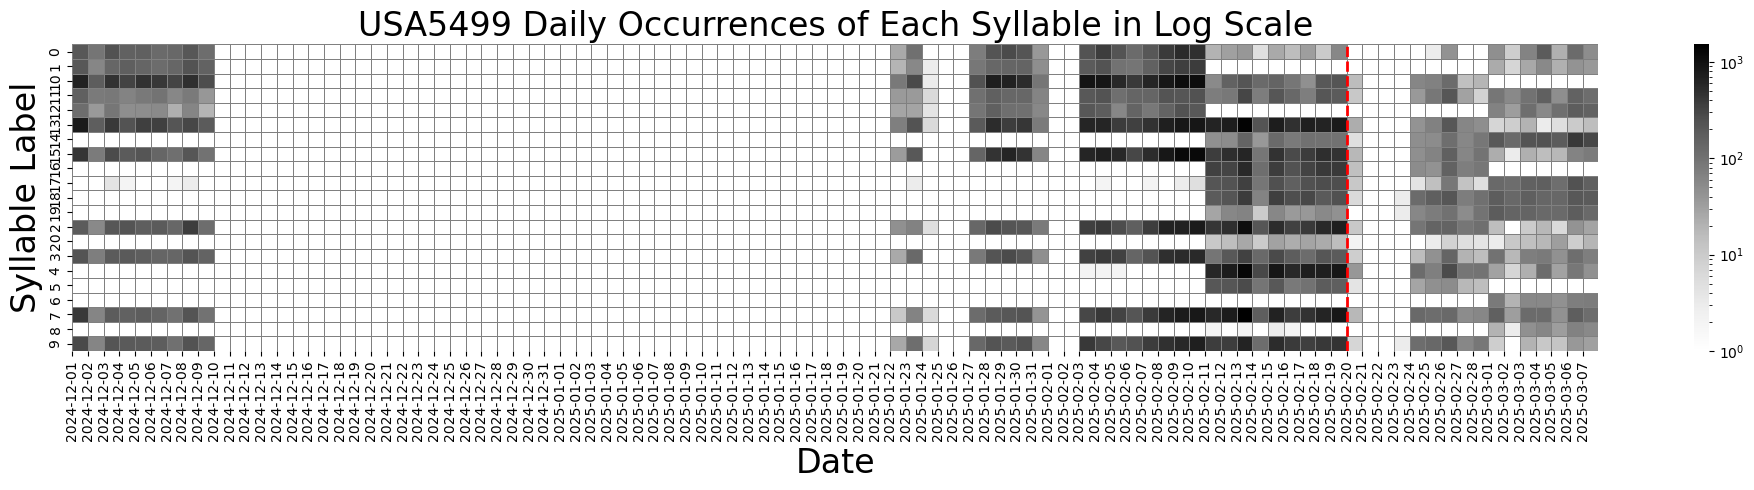

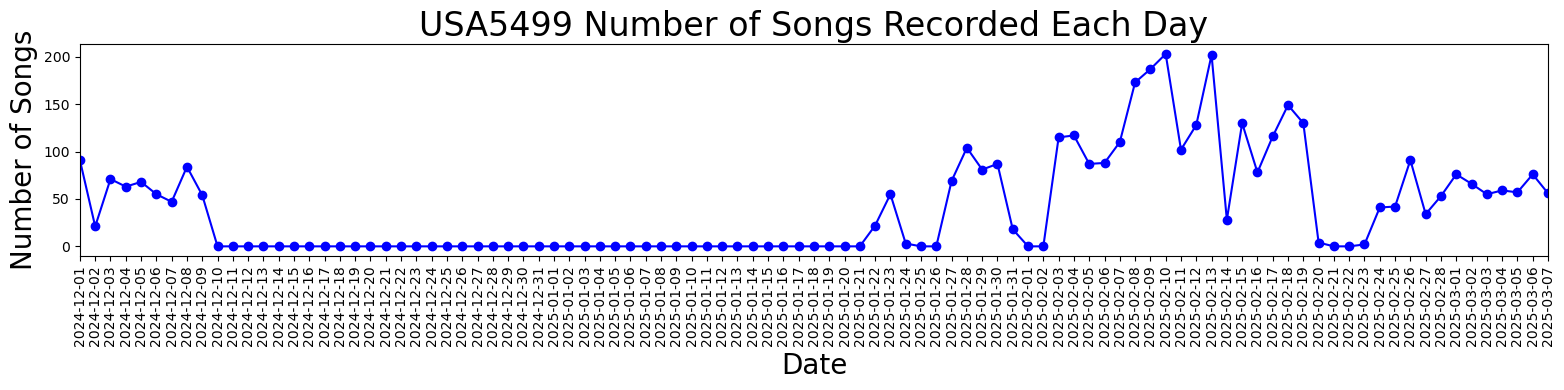

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import numpy as np

# Convert Unix timestamps in 'Date' column to datetime format if needed
organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], unit='s')  # Assumes Unix timestamps in seconds

# Find the minimum and maximum date of recording
min_date = organized_data_frame['Date'].min()
max_date = organized_data_frame['Date'].max()

# Generate a date range with a daily frequency from min_date to max_date
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Create a DataFrame to hold the syllable counts with syllable labels as rows and dates as columns
heatmap_data = pd.DataFrame(0, index=unique_syllable_labels, columns=all_dates)

# Initialize a list to store the number of songs per date
song_counts = []

# Fill the DataFrame with counts for each syllable label on each date and record the song count
for current_date in all_dates:
    daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    
    # Count the number of songs for this date and add to the list
    num_songs = len(daily_data)
    song_counts.append(num_songs)
    print(f"Date: {current_date.strftime('%Y-%m-%d')}, Number of songs: {num_songs}")
    
    if not daily_data.empty:
        for syllable_label in unique_syllable_labels:
            # Sum occurrences of the syllable label for all songs on this date
            daily_count = sum(len(song.get(syllable_label, [])) for song in daily_data['syllable_onsets_offsets_ms_dict'])
            heatmap_data.at[syllable_label, current_date] = daily_count

# Plot the number of songs for each date
# plt.figure(figsize=(20, 6))
# plt.plot(all_dates, song_counts, marker='o', linestyle='-', color='b')
# plt.title('Number of Songs Recorded Each Day', fontsize=24)
# plt.xlabel('Date', fontsize=20)
# plt.ylabel('Number of Songs', fontsize=20)

# Set x-ticks to match all dates in all_dates, and label them
# plt.xticks(ticks=all_dates, labels=all_dates.strftime('%Y-%m-%d'), rotation=90)
# plt.tight_layout()
# plt.show()

# Uncomment one of the following three options to apply different scaling methods:

# Option 1: Logarithmic scale (adds +1 to avoid log(0) issues)
# plt.figure(figsize=(20, 10))
# ax = sns.heatmap(heatmap_data + 1, cmap="Greys", norm=LogNorm(), linewidths=0.5, linecolor='gray', 
#                  cbar_kws={'label': 'Syllable Count (Log Scale)'})
# plt.title('Daily Occurrences of Each Syllable in Log Scale', fontsize=24)

plt.figure(figsize=(20, 5))
ax = sns.heatmap(heatmap_data + 1, cmap="Greys", norm=LogNorm(), linewidths=0.5, linecolor='gray')
plt.title(f'{animal_id} Daily Occurrences of Each Syllable in Log Scale', fontsize=24)

# Option 2: Clipping outliers to a maximum value (e.g., 1000)
# plt.figure(figsize=(20, 10))
# ax = sns.heatmap(heatmap_data.clip(upper=1000), cmap="Greys", linewidths=0.5, linecolor='gray', 
#                  cbar_kws={'label': 'Syllable Count (Clipped to 1000)'})
# plt.title('Daily Occurrences of Each Syllable - Clipped to 1000', fontsize=18)

# Option 3: Square root transformation
# plt.figure(figsize=(20, 10))
# ax = sns.heatmap(np.sqrt(heatmap_data), cmap="Greys", linewidths=0.5, linecolor='gray', 
#                  cbar_kws={'label': 'Syllable Count (Square Root Transformed)'})
# plt.title('Daily Occurrences of Each Syllable - Square Root Transformed', fontsize=18)

# Set x-ticks and convert them to strings for proper labeling
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Syllable Label', fontsize=24)

# Add a vertical red line at the treatment date
#treatment_date = pd.to_datetime('2024-01-24')
if treatment_date in heatmap_data.columns:
    treatment_index = heatmap_data.columns.get_loc(treatment_date)
    ax.axvline(x=treatment_index, color='red', linestyle='--', linewidth=2, label='Treatment Date')
    
plt.tight_layout()
plt.show()# Plot the number of songs for each date
plt.figure(figsize=(15.75, 4))
plt.plot(all_dates, song_counts, marker='o', linestyle='-', color='b')
plt.title(f'{animal_id} Number of Songs Recorded Each Day', fontsize=24)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Songs', fontsize=20)

# Set x-ticks to match all dates in all_dates, and label them
plt.xticks(ticks=all_dates, labels=all_dates.strftime('%Y-%m-%d'), rotation=90)

# Set the x-axis limits to remove the gap
plt.xlim([all_dates[0], all_dates[-1]])

plt.tight_layout()
plt.show()



### Fix alignment between the xtick labels

In [24]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.colors import LogNorm
# import numpy as np

# # Assuming heatmap_data and song_counts are already created as shown in previous code

# # Create a figure with two subplots (stacked vertically) with heatmap on top
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), gridspec_kw={'height_ratios': [3, 1]})

# # Plot 1: Heatmap of Daily Occurrences of Each Syllable (Top)
# sns.heatmap(
#     heatmap_data + 1, 
#     ax=ax1, 
#     cmap="Greys", 
#     norm=LogNorm(), 
#     linewidths=0.5, 
#     linecolor='gray', 
#     cbar_kws={'label': 'Syllable Count (Log Scale)'}
# )
# ax1.set_title(f'{animal_id} Daily Occurrences of Each Syllable in Log Scale', fontsize=24)
# ax1.set_xlabel('Date', fontsize=20)
# ax1.set_ylabel('Syllable Label', fontsize=20)

# # Set x-ticks and labels for the heatmap
# ax1.set_xticks(range(len(heatmap_data.columns)))
# ax1.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

# # Plot 2: Number of Songs Recorded Each Day (Bottom)
# ax2.plot(all_dates, song_counts, marker='o', linestyle='-', color='b')
# # Remove the title for the song count plot
# ax2.set_xlabel('Date', fontsize=20)
# ax2.set_ylabel('Number of Songs', fontsize=20)

# # Set x-ticks to match all dates in all_dates, and label them
# ax2.set_xticks(all_dates)
# ax2.set_xticklabels(all_dates.strftime('%Y-%m-%d'), rotation=90)

# # Set the x-axis limits to align with the heatmap
# ax2.set_xlim([all_dates[0], all_dates[-1]])

# # Adjust layout to make sure plots are not overlapping
# plt.tight_layout()
# plt.show()


# Now, normalize the results by dividing by the number of songs from each day:

Date: 2024-12-01, Number of Songs: 91
Date: 2024-12-02, Number of Songs: 21
Date: 2024-12-03, Number of Songs: 71
Date: 2024-12-04, Number of Songs: 63
Date: 2024-12-05, Number of Songs: 68
Date: 2024-12-06, Number of Songs: 55
Date: 2024-12-07, Number of Songs: 47
Date: 2024-12-08, Number of Songs: 84
Date: 2024-12-09, Number of Songs: 54
Date: 2024-12-10, Number of Songs: 0
Date: 2024-12-11, Number of Songs: 0
Date: 2024-12-12, Number of Songs: 0
Date: 2024-12-13, Number of Songs: 0
Date: 2024-12-14, Number of Songs: 0
Date: 2024-12-15, Number of Songs: 0
Date: 2024-12-16, Number of Songs: 0
Date: 2024-12-17, Number of Songs: 0
Date: 2024-12-18, Number of Songs: 0
Date: 2024-12-19, Number of Songs: 0
Date: 2024-12-20, Number of Songs: 0
Date: 2024-12-21, Number of Songs: 0
Date: 2024-12-22, Number of Songs: 0
Date: 2024-12-23, Number of Songs: 0
Date: 2024-12-24, Number of Songs: 0
Date: 2024-12-25, Number of Songs: 0
Date: 2024-12-26, Number of Songs: 0
Date: 2024-12-27, Number of S

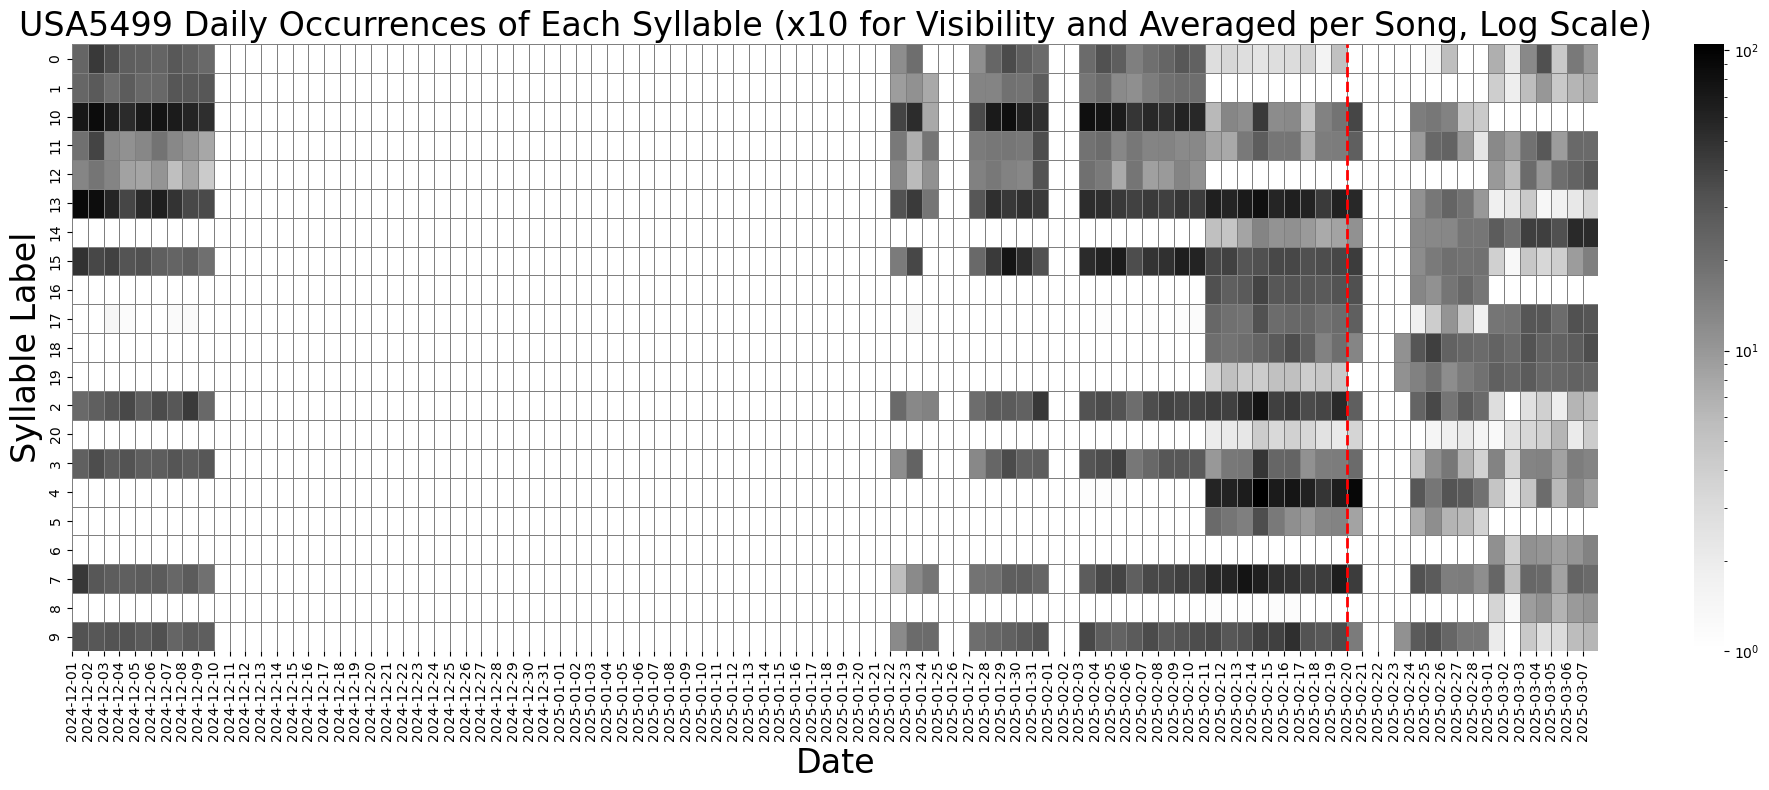

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import LogNorm

# Convert Unix timestamps in 'Date' column to datetime format if needed
organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], unit='s')  # Assumes Unix timestamps in seconds

# Find the minimum and maximum date of recording
min_date = organized_data_frame['Date'].min()
max_date = organized_data_frame['Date'].max()

# Generate a date range with a daily frequency from min_date to max_date
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Create a DataFrame to hold the syllable counts with syllable labels as rows and dates as columns
# Initialize with floats by setting the initial values to 0.0
heatmap_data = pd.DataFrame(0.0, index=unique_syllable_labels, columns=all_dates)

# Fill the DataFrame with counts for each syllable label on each date
for current_date in all_dates:
    daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    
    # Count the number of songs on this date
    num_songs = len(daily_data)
    print(f"Date: {current_date.strftime('%Y-%m-%d')}, Number of Songs: {num_songs}")
    
    if num_songs > 0:  # Only proceed if there are songs for this date
        for syllable_label in unique_syllable_labels:
            # Sum occurrences of the syllable label for all songs on this date
            total_count = sum(len(song.get(syllable_label, [])) for song in daily_data['syllable_onsets_offsets_ms_dict'])
            # Divide by the number of songs to get the average occurrences per song
            average_count = total_count / (num_songs*0.1)
            heatmap_data.at[syllable_label, current_date] = average_count

# Plot the heatmap with a logarithmic color scale
plt.figure(figsize=(20, 8))
ax = sns.heatmap(heatmap_data + 1, cmap="Greys", norm=LogNorm(), linewidths=0.5, linecolor='gray')
plt.title(f'{animal_id} Daily Occurrences of Each Syllable (x10 for Visibility and Averaged per Song, Log Scale)', fontsize=24)

# Add a vertical red line at the treatment date
#treatment_date = pd.to_datetime('2024-01-24')
if treatment_date in heatmap_data.columns:
    treatment_index = heatmap_data.columns.get_loc(treatment_date)
    ax.axvline(x=treatment_index, color='red', linestyle='--', linewidth=2, label='Treatment Date')
    #plt.legend(fontsize=16)

# Set x-ticks and convert them to strings for proper labeling
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Syllable Label', fontsize=24)
plt.tight_layout()
plt.show()


## Make a heat map of how much time (ms) the bird spend singing the each syllable each day

In [26]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Define the list of unique syllable labels
# # unique_syllable_labels = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', 
# #                           '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', 
# #                           '7', '8', '9']

# # Find the minimum and maximum date of recording
# min_date = organized_data_frame['Date'].min()
# max_date = organized_data_frame['Date'].max()

# # Generate a date range with a daily frequency from min_date to max_date
# all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# # Dictionary to store syllable time per day for each unique syllable label
# syllable_time_per_day = {syllable_label: [] for syllable_label in unique_syllable_labels}

# # Loop through each unique syllable label
# for syllable_label in unique_syllable_labels:
#     # Loop through each date in the range to sum the singing time of the target syllable
#     for current_date in all_dates:
#         # Filter data for the current date
#         daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
        
#         # Check if there is data for the current date
#         if not daily_data.empty:
#             # Total singing time for the syllable on this date
#             daily_total_time = 0
#             for song in daily_data['syllable_onsets_offsets_ms_dict']:
#                 # If the syllable label exists in the song data, calculate its total singing time
#                 if syllable_label in song:
#                     phrase_durations = [
#                         occurrence[1] - occurrence[0] for occurrence in song[syllable_label]
#                     ]
#                     daily_total_time += sum(phrase_durations)
#             syllable_time_per_day[syllable_label].append(daily_total_time)
#         else:
#             syllable_time_per_day[syllable_label].append(0)  # No singing time if no data for this date

# # Plot total singing time per day for each syllable label
# plt.figure(figsize=(20, 10))
# for syllable_label, daily_times in syllable_time_per_day.items():
#     plt.plot(all_dates, daily_times, label=f'Syllable {syllable_label}')

# # Configure plot with labels, title, and x-tick for every day in the date range
# plt.xlabel('Date', fontsize=24)
# plt.ylabel('Total Singing Time (ms)', fontsize=24)
# plt.title(f'{animal_id} Daily Total Singing Time for Each Syllable Label', fontsize=24)
# plt.xticks(rotation=90)
# plt.legend(title='Syllable Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Ensure all dates are displayed
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.tight_layout()
# plt.show()


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/4084331663.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25.680793650793625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.at[syllable_label, current_date] = daily_total_time
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/4084331663.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.286190476190484' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.at[syllable_label, current_date] = daily_total_time
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/4084331663.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.96380952380955' 

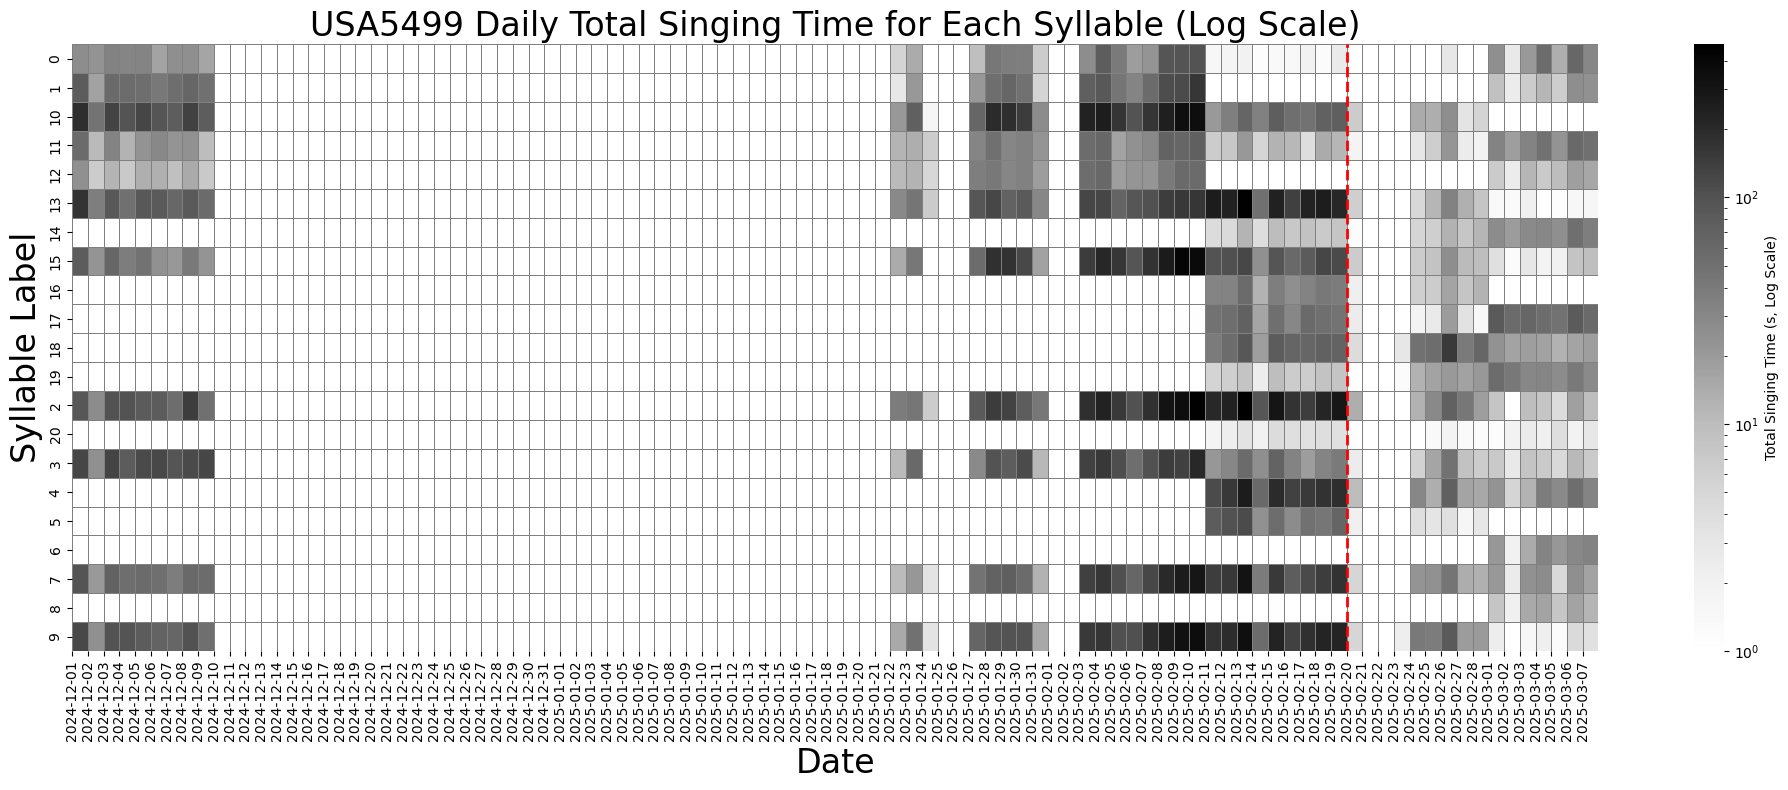

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Convert Unix timestamps in 'Date' column to datetime format if needed
organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], unit='s')  # Assumes Unix timestamps in seconds

# # Define unique syllable labels
# unique_syllable_labels = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', 
#                           '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', 
#                           '7', '8', '9']

# Find the minimum and maximum date of recording
min_date = organized_data_frame['Date'].min()
max_date = organized_data_frame['Date'].max()

# Generate a date range with a daily frequency from min_date to max_date
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Create a DataFrame to hold the total time spent singing each syllable (in seconds) with syllable labels as rows and dates as columns
heatmap_data = pd.DataFrame(0, index=unique_syllable_labels, columns=all_dates)

# Fill the DataFrame with total singing time in seconds for each syllable label on each date
for current_date in all_dates:
    daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    
    if not daily_data.empty:
        for syllable_label in unique_syllable_labels:
            # Sum total time for the syllable label across all songs on this date, converting to seconds
            daily_total_time = 0
            for song in daily_data['syllable_onsets_offsets_ms_dict']:
                if syllable_label in song:
                    phrase_durations = [(occurrence[1] - occurrence[0]) / 1000 for occurrence in song[syllable_label]]
                    daily_total_time += sum(phrase_durations)
            heatmap_data.at[syllable_label, current_date] = daily_total_time

# Plot heatmap with log scale
plt.figure(figsize=(20, 8))
ax = sns.heatmap(heatmap_data + 1, cmap="Greys", norm=LogNorm(), linewidths=0.5, linecolor='gray',
                 cbar_kws={'label': 'Total Singing Time (s, Log Scale)'})
plt.title(f'{animal_id} Daily Total Singing Time for Each Syllable (Log Scale)', fontsize=24)

# Add a vertical red line at the treatment date
#treatment_date = pd.to_datetime('2024-01-24')
if treatment_date in heatmap_data.columns:
    treatment_index = heatmap_data.columns.get_loc(treatment_date)
    ax.axvline(x=treatment_index, color='red', linestyle='--', linewidth=2, label='Treatment Date')

# Configure x-ticks for each date and format them
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Syllable Label', fontsize=24)
plt.tight_layout()
plt.show()


## Now, average each amount of time spent singing by the number of songs

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/137390372.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25.680793650793625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.at[syllable_label, current_date] = daily_total_time
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/137390372.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.286190476190484' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.at[syllable_label, current_date] = daily_total_time
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/137390372.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.96380952380955' has

Date-wise Total Singing Time (seconds):
2024-12-01: 1046.78 seconds
2024-12-02: 249.51 seconds
2024-12-03: 801.64 seconds
2024-12-04: 603.80 seconds
2024-12-05: 706.26 seconds
2024-12-06: 610.40 seconds
2024-12-07: 509.53 seconds
2024-12-08: 795.15 seconds
2024-12-09: 509.50 seconds
2024-12-10: 0.00 seconds
2024-12-11: 0.00 seconds
2024-12-12: 0.00 seconds
2024-12-13: 0.00 seconds
2024-12-14: 0.00 seconds
2024-12-15: 0.00 seconds
2024-12-16: 0.00 seconds
2024-12-17: 0.00 seconds
2024-12-18: 0.00 seconds
2024-12-19: 0.00 seconds
2024-12-20: 0.00 seconds
2024-12-21: 0.00 seconds
2024-12-22: 0.00 seconds
2024-12-23: 0.00 seconds
2024-12-24: 0.00 seconds
2024-12-25: 0.00 seconds
2024-12-26: 0.00 seconds
2024-12-27: 0.00 seconds
2024-12-28: 0.00 seconds
2024-12-29: 0.00 seconds
2024-12-30: 0.00 seconds
2024-12-31: 0.00 seconds
2025-01-01: 0.00 seconds
2025-01-02: 0.00 seconds
2025-01-03: 0.00 seconds
2025-01-04: 0.00 seconds
2025-01-05: 0.00 seconds
2025-01-06: 0.00 seconds
2025-01-07: 0.00

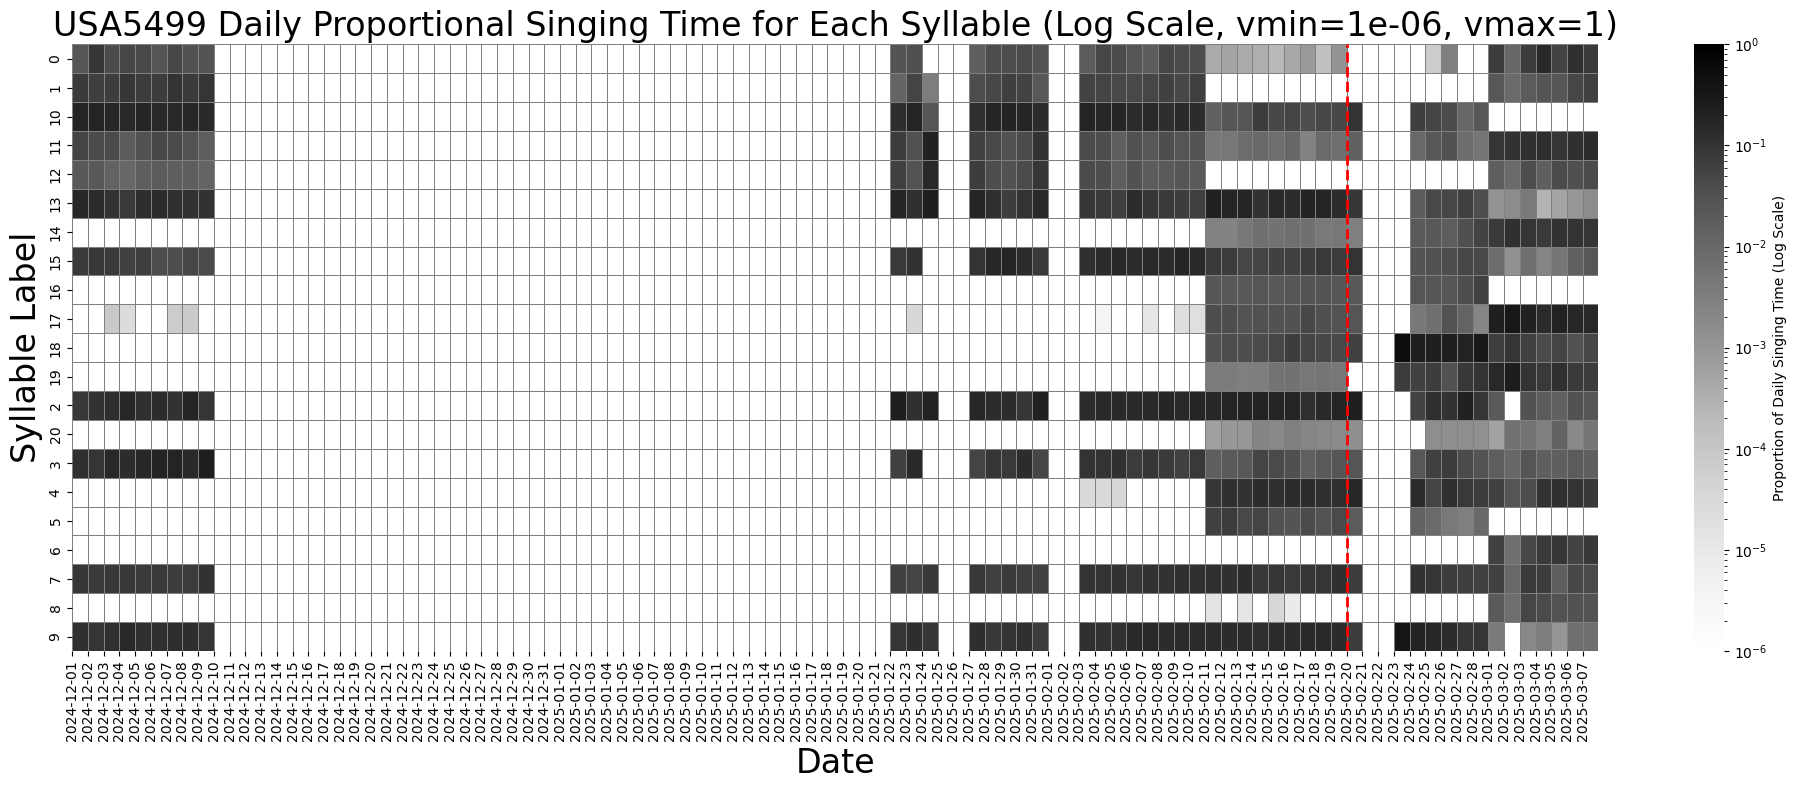

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Convert Unix timestamps in 'Date' column to datetime format if needed
organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], unit='s')  # Assumes Unix timestamps in seconds

# Define unique syllable labels
# unique_syllable_labels = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', 
#                           '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', 
#                           '7', '8', '9']

# Find the minimum and maximum date of recording
min_date = organized_data_frame['Date'].min()
max_date = organized_data_frame['Date'].max()

# Generate a date range with a daily frequency from min_date to max_date
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Create a DataFrame to hold the total time spent singing each syllable (in seconds) with syllable labels as rows and dates as columns
heatmap_data = pd.DataFrame(0, index=unique_syllable_labels, columns=all_dates)

# Create a list to store total singing time for each day
daily_total_singing_time = []

# Fill the DataFrame with total singing time in seconds for each syllable label on each date
for current_date in all_dates:
    daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    total_time_for_day = 0  # Track total singing time for the day

    if not daily_data.empty:
        for syllable_label in unique_syllable_labels:
            # Sum total time for the syllable label across all songs on this date, converting to seconds
            daily_total_time = 0
            for song in daily_data['syllable_onsets_offsets_ms_dict']:
                if syllable_label in song:
                    phrase_durations = [(occurrence[1] - occurrence[0]) / 1000 for occurrence in song[syllable_label]]
                    daily_total_time += sum(phrase_durations)

            heatmap_data.at[syllable_label, current_date] = daily_total_time
            total_time_for_day += daily_total_time

    daily_total_singing_time.append((current_date, total_time_for_day))

# Normalize the heatmap data by dividing each syllable's total time by the total singing time for that day
for current_date, total_time_for_day in daily_total_singing_time:
    if total_time_for_day > 0:  # Avoid division by zero
        heatmap_data[current_date] = (heatmap_data[current_date] / total_time_for_day)

# Print total singing time for each day
print("Date-wise Total Singing Time (seconds):")
for date, total_time in daily_total_singing_time:
    print(f"{date.strftime('%Y-%m-%d')}: {total_time:.2f} seconds")

# Plot heatmap with log scale and adjusted colormap scaling
vmin = 1e-6
vmax = 1
plt.figure(figsize=(20, 8))
ax = sns.heatmap(heatmap_data + 1e-9, cmap="Greys", norm=LogNorm(vmin=vmin, vmax=vmax), linewidths=0.5, linecolor='gray',
                 cbar_kws={'label': 'Proportion of Daily Singing Time (Log Scale)'})
plt.title(f'{animal_id} Daily Proportional Singing Time for Each Syllable (Log Scale, vmin={vmin}, vmax={vmax})', fontsize=24)

# Add a vertical red line at the treatment date
#treatment_date = pd.to_datetime('2024-01-24')
if treatment_date in heatmap_data.columns:
    treatment_index = heatmap_data.columns.get_loc(treatment_date)
    ax.axvline(x=treatment_index, color='red', linestyle='--', linewidth=2, label='Treatment Date')
#    plt.legend(fontsize=16)

# Configure x-ticks for each date and format them
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Syllable Label', fontsize=24)
plt.tight_layout()
plt.show()


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/301134067.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25.680793650793625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.at[syllable_label, current_date] = daily_total_time
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/301134067.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.286190476190484' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.at[syllable_label, current_date] = daily_total_time
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_9777/301134067.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.96380952380955' has

Date-wise Total Singing Time (seconds):
2024-12-01: 1046.78 seconds
2024-12-02: 249.51 seconds
2024-12-03: 801.64 seconds
2024-12-04: 603.80 seconds
2024-12-05: 706.26 seconds
2024-12-06: 610.40 seconds
2024-12-07: 509.53 seconds
2024-12-08: 795.15 seconds
2024-12-09: 509.50 seconds
2024-12-10: 0.00 seconds
2024-12-11: 0.00 seconds
2024-12-12: 0.00 seconds
2024-12-13: 0.00 seconds
2024-12-14: 0.00 seconds
2024-12-15: 0.00 seconds
2024-12-16: 0.00 seconds
2024-12-17: 0.00 seconds
2024-12-18: 0.00 seconds
2024-12-19: 0.00 seconds
2024-12-20: 0.00 seconds
2024-12-21: 0.00 seconds
2024-12-22: 0.00 seconds
2024-12-23: 0.00 seconds
2024-12-24: 0.00 seconds
2024-12-25: 0.00 seconds
2024-12-26: 0.00 seconds
2024-12-27: 0.00 seconds
2024-12-28: 0.00 seconds
2024-12-29: 0.00 seconds
2024-12-30: 0.00 seconds
2024-12-31: 0.00 seconds
2025-01-01: 0.00 seconds
2025-01-02: 0.00 seconds
2025-01-03: 0.00 seconds
2025-01-04: 0.00 seconds
2025-01-05: 0.00 seconds
2025-01-06: 0.00 seconds
2025-01-07: 0.00

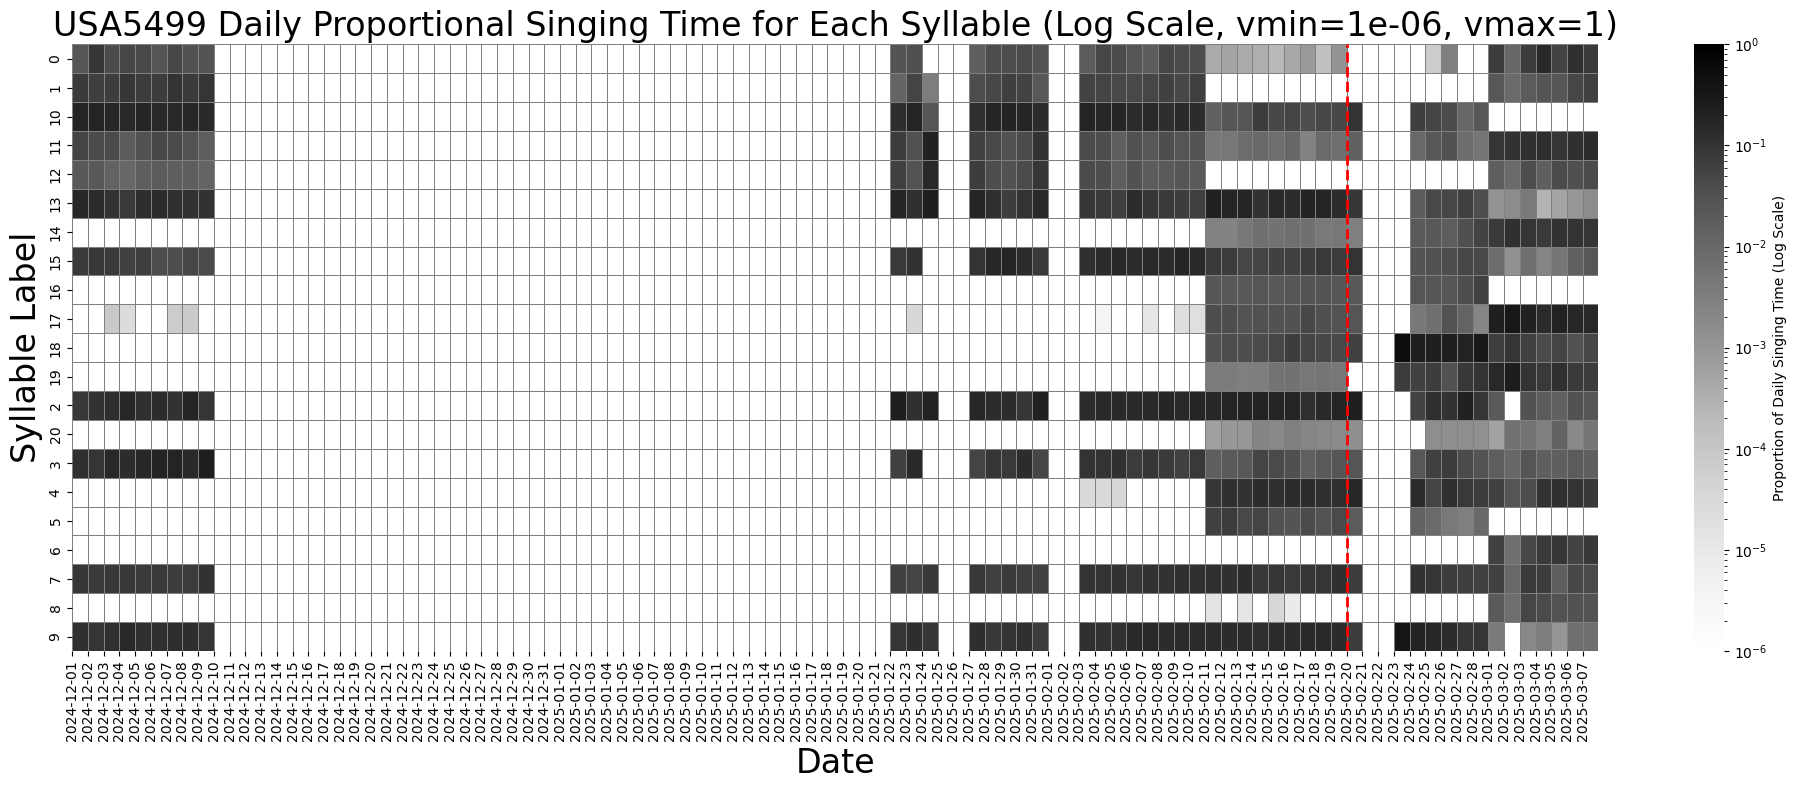

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Convert Unix timestamps in 'Date' column to datetime format if needed
organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], unit='s')  # Assumes Unix timestamps in seconds

# # Define unique syllable labels
# unique_syllable_labels = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', 
#                           '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', 
#                           '7', '8', '9']

# Find the minimum and maximum date of recording
min_date = organized_data_frame['Date'].min()
max_date = organized_data_frame['Date'].max()

# Generate a date range with a daily frequency from min_date to max_date
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Create a DataFrame to hold the total time spent singing each syllable (in seconds) with syllable labels as rows and dates as columns
heatmap_data = pd.DataFrame(0, index=unique_syllable_labels, columns=all_dates)

# Create a list to store total singing time for each day
daily_total_singing_time = []

# Fill the DataFrame with total singing time in seconds for each syllable label on each date
for current_date in all_dates:
    daily_data = organized_data_frame[organized_data_frame['Date'] == current_date]
    total_time_for_day = 0  # Track total singing time for the day

    if not daily_data.empty:
        for syllable_label in unique_syllable_labels:
            # Sum total time for the syllable label across all songs on this date, converting to seconds
            daily_total_time = 0
            for song in daily_data['syllable_onsets_offsets_ms_dict']:
                if syllable_label in song:
                    phrase_durations = [(occurrence[1] - occurrence[0]) / 1000 for occurrence in song[syllable_label]]
                    daily_total_time += sum(phrase_durations)

            heatmap_data.at[syllable_label, current_date] = daily_total_time
            total_time_for_day += daily_total_time

    daily_total_singing_time.append((current_date, total_time_for_day))

# Normalize the heatmap data by dividing each syllable's total time by the total singing time for that day
for current_date, total_time_for_day in daily_total_singing_time:
    if total_time_for_day > 0:  # Avoid division by zero
        heatmap_data[current_date] = (heatmap_data[current_date] / total_time_for_day)

# Print total singing time for each day
print("Date-wise Total Singing Time (seconds):")
for date, total_time in daily_total_singing_time:
    print(f"{date.strftime('%Y-%m-%d')}: {total_time:.2f} seconds")

# Plot heatmap with log scale and adjusted colormap scaling
vmin = 1e-6
vmax = 1
plt.figure(figsize=(20, 8))
ax = sns.heatmap(heatmap_data + 1e-9, cmap="Greys", norm=LogNorm(vmin=vmin, vmax=vmax), linewidths=0.5, linecolor='gray',
                 cbar_kws={'label': 'Proportion of Daily Singing Time (Log Scale)'})

# Add a vertical red line at the treatment date
#treatment_date = pd.to_datetime('2024-01-24')
if treatment_date in heatmap_data.columns:
    treatment_index = heatmap_data.columns.get_loc(treatment_date)
    ax.axvline(x=treatment_index, color='red', linestyle='--', linewidth=2, label='Treatment Date')
#    plt.legend(fontsize=16)

plt.title(f'{animal_id} Daily Proportional Singing Time for Each Syllable (Log Scale, vmin={vmin}, vmax={vmax})', fontsize=24)

# Configure x-ticks for each date and format them
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns.strftime('%Y-%m-%d'), rotation=90)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Syllable Label', fontsize=24)
plt.tight_layout()
plt.show()

## Plot a subset of the data (use if we didn't have continuous recordings for a bird, for example, if we stopped recording during winter break)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Define the date range for the subset
date_start = pd.to_datetime('2024-01-04')
date_end = pd.to_datetime('2024-02-07')
subset_dates = pd.date_range(start=date_start, end=date_end, freq='D')

# Subset the heatmap data to the desired date range
heatmap_subset = heatmap_data[subset_dates]

# Plot the subset heatmap with log scale and adjusted colormap scaling
plt.figure(figsize=(20, 6))
ax = sns.heatmap(heatmap_subset + 1e-9, cmap="Greys", norm=LogNorm(vmin=vmin, vmax=vmax), linewidths=0.5, linecolor='gray',
                 cbar_kws={'label': 'Proportion of Daily Singing Time (Log Scale)'})

# Add a vertical red line at the treatment date if within the subset
# treatment_date = pd.to_datetime('2024-01-24')
if treatment_date in heatmap_subset.columns:
    treatment_index = heatmap_subset.columns.get_loc(treatment_date)
    ax.axvline(x=treatment_index, color='red', linestyle='--', linewidth=2, label='Treatment Date')
    #plt.legend(fontsize=16, loc = 'lower right')

plt.title(f'{animal_id} Subset Proportional Singing Time for Each Syllable (Log Scale, vmin={vmin}, vmax={vmax})', fontsize=24)

# Configure x-ticks for the subset and format them
ax.set_xticks(range(len(heatmap_subset.columns)))
ax.set_xticklabels(heatmap_subset.columns.strftime('%Y-%m-%d'), rotation=90)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Syllable Label', fontsize=24)
plt.tight_layout()
plt.show()


KeyError: "None of [DatetimeIndex(['2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07',\n               '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',\n               '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-15',\n               '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19',\n               '2024-01-20', '2024-01-21', '2024-01-22', '2024-01-23',\n               '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-27',\n               '2024-01-28', '2024-01-29', '2024-01-30', '2024-01-31',\n               '2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',\n               '2024-02-05', '2024-02-06', '2024-02-07'],\n              dtype='datetime64[ns]', freq='D')] are in the [columns]"